In [1]:
# Imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from pathlib import Path
from pandas import read_csv, DataFrame, MultiIndex
from enum import Enum
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt

In [2]:
# Stores the different vectorizers
class Vectorizers(Enum):
    Tf_idf = TfidfVectorizer()
    Unigram = CountVectorizer()
    Bigram = CountVectorizer(ngram_range = (2,2))

In [3]:
# Stores the different models
class Models(Enum):
    LogisticRegression = LogisticRegression()
    MultinomialNB = MultinomialNB()
    RandomForest = RandomForestClassifier()
    SVM = LinearSVC()
    Perceptron = Perceptron()
    
    # Returns all models in a list 
    @classmethod
    def list(self):
        return list(map(lambda x: x.value, self))

In [4]:
# Stores the data matricies
class Data:
    # Object initalization
    # Args   : datafile: A filename that contains raw data
    # Returns: The Data object
    def __init__(self, datafile):
        self.Raw = datafile
        
    # Stores the vectorized count matrix of a unigram data model
    @property
    def UnigramMatrix(self):
        if not hasattr(self, '__unigramMatrix'):
            matrix = {}         
            matrix['X'] = Vectorizers.Unigram.value.fit_transform(self.Raw.X)
            matrix['Y'] = self.Raw.Y
            self.__countMatrix = matrix
        return self.__countMatrix
    
    # Stores the vectorized count matrix of a bigram data model
    @property
    def BigramMatrix(self):
        if not hasattr(self, '__bigramMatrix'):
            matrix = {}         
            matrix['X'] = Vectorizers.Bigram.value.fit_transform(self.Raw.X)
            matrix['Y'] = self.Raw.Y
            self.__bigramMatrix = matrix
        return self.__bigramMatrix
    
    # Stores the vectorized td-idf matrix
    @property
    def Tf_idfMatrix(self):
        if not hasattr(self, '__tfidfMatrix'):
            matrix = {}         
            matrix['X'] = Vectorizers.Tf_idf.value.fit_transform(self.Raw.X)
            matrix['Y'] = self.Raw.Y
            self.__tfidfMatrix = matrix
        return self.__tfidfMatrix
    
    # Stores the dataframe with the raw data
    @property
    def Raw(self):
        return self.__raw
    
    @Raw.setter
    def Raw(self, datafile):
        data = read_csv(datafile) 
        if data.shape[1] != 2:
            raise ValueError('Your raw datafile must have 2 columns.')
        data.columns = ['X', 'Y']
        self.__raw = data

In [40]:
# CFA class for CFA analysis
class CFA:
    # Object initalization
    # Args   : features: The features to perform CFA
    #        : data: The data to use for 
    # Returns: The CFA object
    def __init__(self, features, data):
        self.Features = features
        self.Data = data
        self.FitModels()
            
    # Property to hold the input dataset
    @property
    def Data(self):
        return self.__data
    
    @Data.setter
    def Data(self, data):
        self.__data = data
    
    # Property to return the training set and initalize the test sets
    @property
    def TrainSet(self):
        if not hasattr(self, '__trainSet'):
            TrainSetX, TestSetX, TrainSetY, TestSetY = train_test_split(self.Data['X'], self.Data['Y'], test_size = .2, random_state = 1)
            self.TestX1, self.TestX2, self.TestY1, self.TestY2 = train_test_split(TestSetX, TestSetY, test_size = .5, random_state = 1)
            self.__trainSet = (TrainSetX, TrainSetY)
        return self.__trainSet
              
    # Property to record scores
    @property
    def Scores(self):        
        if not hasattr(self, '__scores'):
            modelNames = [model.name for model in self.Features]
            index = ['d{}'.format(x) for x in range(1, self.TestX1.shape[0] + 1)]
            cols = MultiIndex.from_product([modelNames, ['Negative', 'Neutral', 'Positive']], names = ['Feature', 'Class'])
            self.__scores = DataFrame(index = index, columns = cols)
            for model in self.Features:
                if hasattr(model.value, 'predict_proba'):
                    scores = DataFrame(model.value.predict_proba(self.TestX1), index, ['Negative', 'Neutral', 'Positive'])                   
                else:
                    scores = DataFrame(model.value.decision_function(self.TestX1), index, ['Negative', 'Neutral', 'Positive'])
                self.__scores[model.name] = scores
        return self.__scores
    
    # Positive Scores
    @property
    def PosScores(self):
        if not hasattr(self, '__posScores'):
            scores = self.Scores.xs('Positive', level = 'Class', axis = 1)
            self.__posScores = DataFrame(index = scores.index)
            for col in scores:
                self.__posScores[col] = MinMaxScaler().fit_transform(scores[col].values.reshape(-1, 1))
        return self.__posScores
    
    # Negative Scores
    @property
    def NegScores(self):
        if not hasattr(self, '__negScores'):
            scores = self.Scores.xs('Negative', level = 'Class', axis = 1)
            self.__negScores = DataFrame(index = scores.index)
            for col in scores:
                self.__negScores[col] = MinMaxScaler().fit_transform(scores[col].values.reshape(-1, 1))
        return self.__negScores
    
    # Neutral Scores
    @property
    def NeuScores(self):
        if not hasattr(self, '__neuScores'):
            scores = self.Scores.xs('Neutral', level = 'Class', axis = 1)
            self.__neuScores = DataFrame(index = scores.index)
            for col in scores:
                self.__neuScores[col] = MinMaxScaler().fit_transform(scores[col].values.reshape(-1, 1))
        return self.__neuScores
    
    # Positive Ranks
    @property 
    def PosRanks(self):
        if not hasattr(self, '__posRanks'):
            ranks = DataFrame(index = self.PosScores.index)
            for col in self.PosScores.columns:
                ranks[col] = self.PosScores[col].rank(ascending = False)
            self.__posRanks = ranks
        return self.__posRanks
    
    # Negative Ranks
    @property 
    def NegRanks(self):
        if not hasattr(self, '__negRanks'):
            ranks = DataFrame(index = self.NegScores.index)
            for col in self.NegScores.columns:
                ranks[col] = self.NegScores[col].rank(ascending = False)
            self.__negRanks = ranks
        return self.__negRanks
    
    # Neutral Ranks
    @property 
    def NeuRanks(self):
        if not hasattr(self, '__neuRanks'):
            ranks = DataFrame(index = self.NeuScores.index)
            for col in self.NeuScores.columns:
                ranks[col] = self.NeuScores[col].rank(ascending = False)
            self.__neuRanks = ranks
        return self.__neuRanks
    
    # Positive Rank/Score Function
    @property
    def PosRankScore(self):
        if not hasattr(self, '__posRankScore'):
            modelNames = [model.name for model in self.Features]
            columns = MultiIndex.from_product([modelNames, ['Rank', 'Score']])
            rankScore = DataFrame(columns = columns)
            for column in rankScore.columns:
                rankScore[column[0], 'Rank'] = self.PosRanks[column[0]]
                rankScore[column[0], 'Score'] = self.PosScores[column[0]]
            self.__posRankScore = rankScore
        return self.__posRankScore
    
    # Negative Rank/Score Function
    @property
    def NegRankScore(self):
        if not hasattr(self, '__negRankScore'):
            modelNames = [model.name for model in self.Features]
            columns = MultiIndex.from_product([modelNames, ['Rank', 'Score']])
            rankScore = DataFrame(columns = columns)
            for column in rankScore.columns:
                rankScore[column[0], 'Rank'] = self.NegRanks[column[0]]
                rankScore[column[0], 'Score'] = self.NegScores[column[0]]
            self.__negRankScore = rankScore
        return self.__negRankScore
    
    # Neutral Rank/Score Function
    @property
    def NeuRankScore(self):
        if not hasattr(self, '__neuRankScore'):
            modelNames = [model.name for model in self.Features]
            columns = MultiIndex.from_product([modelNames, ['Rank', 'Score']])
            rankScore = DataFrame(columns = columns)
            for column in rankScore.columns:
                rankScore[column[0], 'Rank'] = self.NeuRanks[column[0]]
                rankScore[column[0], 'Score'] = self.NeuScores[column[0]]
            self.__neuRankScore = rankScore
        return self.__neuRankScore
    
    # Fits the models
    def FitModels(self):
        # This enables multiprocessing as model fitting is the most computationally expensive task
        # This will be slower however with a small amount of models since creating processes has overhead
        with ProcessPoolExecutor() as executor:
            for model in self.Features:
                executor.submit(model.value.fit, self.TrainSet[0], self.TrainSet[1])
        #for model in self.Features:
        #    model.value.fit(self.TrainSet[0], self.TrainSet[1])
            
    # Graph the rank scores
    def graphRankScores(self):
        index = [x for x in range(1, self.PosRankScore.shape[0] + 1)]
        fig = plt.figure(0)
        ax = fig.add_subplot(111)
        for column in self.PosRankScore.columns.get_level_values(0).unique():
            data = self.PosRankScore[column].sort_values(by = "Rank")
            ax.plot(data.Rank, data.Score, label = column)
        ax.set_title('Positive Classifier Diversity')
        ax.set_xlabel('Rank')
        ax.set_ylabel('Score')
        ax.legend()
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        for column in self.NegRankScore.columns.get_level_values(0).unique():
            data = self.NegRankScore[column].sort_values(by = "Rank")
            plt.plot(data.Rank, data.Score, label = column)
        ax.set_title('Negative Classifier Diversity')
        ax.set_xlabel('Rank')
        ax.set_ylabel('Score')
        ax.legend()
        fig = plt.figure(2)
        ax = fig.add_subplot(111)
        for column in self.NeuRankScore.columns.get_level_values(0).unique():
            data = self.NeuRankScore[column].sort_values(by = "Rank")
            plt.plot(data.Rank, data.Score, label = column)
        ax.set_title('Neutral Classifier Diversity')
        ax.set_xlabel('Rank')
        ax.set_ylabel('Score')
        ax.legend()

In [41]:
cfaUnigram = CFA(Models, Data('Tweets.csv').UnigramMatrix)

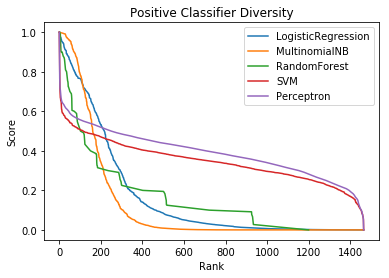

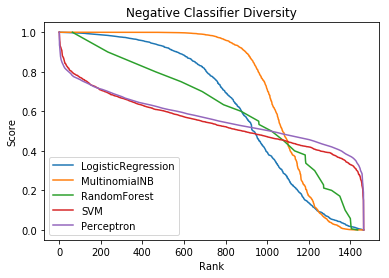

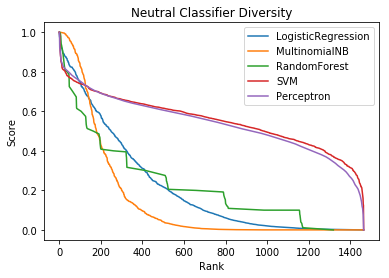

In [42]:
cfaUnigram.graphRankScores()